In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LambdaCallback
from keras import backend as K
import keras
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import Callback
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# ratio of the dataset you wanan use
ratio = 1
subset_size = int(ratio * len(X_train))
X_train = X_train[:subset_size].reshape((subset_size, -1))/255.0
y_train = to_categorical(y_train[:subset_size], 10)

subset_size = int(ratio * len(X_test))
X_test = X_test[:subset_size].reshape((subset_size, -1))/255.0
y_test = to_categorical(y_test[:subset_size], 10)


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,)))
model.add(Dense(128, activation='relu', input_shape=(128,)))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ds_size = 60000  * ratio
batchsize_train = 128
dense_size = 128
n_batches = int(ds_size // batchsize_train)
n_epochs = 6
n_layers = 2

In [ ]:
shapes = (n_batches, batchsize_train, dense_size)

layer_activations = []
for _ in range(n_layers):
  epochs = []
  for i in range(n_epochs):
    epochs.append(np.empty(shapes))
  layer_activations.append(epochs)
model_output = []
weights = []

class CustomCallback(Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()
        for i in range(n_layers):
          model_output.append(model.layers[i].output)
        self.ok = False #used for testing

    def on_epoch_begin(self, epoch, logs=None):
      self.neuron_activations = []
      for i in range(n_layers):
        self.neuron_activations.append(layer_activations[i][epoch])
      if epoch == 0: ## replace 0 with the epoch you wanna test
        self.ok = True

    def on_batch_begin(self, batch, logs=None):
        get_activations = K.function([model.layers[0].input], model_output)
        if batch != (n_batches):  # we ignore the last, uncompleted batch so we can have a matrix
          get_act = get_activations([X_train[(batch) * batchsize_train: (batch + 1) * batchsize_train]])
          for i in range(n_layers):
            activations = get_act[i]
            self.neuron_activations[i][batch]= np.array(activations)
        if batch == 50 and self.ok == True:
           weights.append(model.get_weights())
           self.ok = False

custom_callback = CustomCallback()

model.fit(X_train, y_train, epochs=n_epochs, batch_size=batchsize_train, callbacks=[custom_callback])


Epoch 1/6
  5/469 [..............................] - ETA: 15s - loss: 2.1938 - accuracy: 0.2344

469/469 [==============================] - 25s 47ms/step - loss: 0.3087 - accuracy: 0.9123
Epoch 2/6
469/469 [==============================] - 9s 20ms/step - loss: 0.1224 - accuracy: 0.9637
Epoch 3/6
469/469 [==============================] - 7s 15ms/step - loss: 0.0844 - accuracy: 0.9745
Epoch 4/6
469/469 [==============================] - 6s 14ms/step - loss: 0.0624 - accuracy: 0.9812
Epoch 5/6
469/469 [==============================] - 7s 16ms/step - loss: 0.0494 - accuracy: 0.9846
Epoch 6/6
469/469 [==============================] - 6s 13ms/step - loss: 0.0383 - accuracy: 0.9880


Properly arrange list

In [ ]:
neuron_activations = []
for j in range(n_layers):
  for i in range(n_epochs):
    layer_activations[j][i] = np.reshape(layer_activations[j][i], (n_batches * batchsize_train, dense_size ))
    layer_activations[j][i] = layer_activations[j][i].T.reshape((dense_size,-1))
  neuron_activations.append(np.hstack(layer_activations[j]))


Remove top and bottom 5%


In [ ]:
ammount_removed = 0.025

In [ ]:
remove_count = int(len(neuron_activations[0][0]) * ammount_removed)
neuron_activations_no_outliers = np.empty((2,128, (len(neuron_activations[0][0]) - 2 * remove_count)))
for layer_ in range(n_layers):
  for neuron_ in range(dense_size):
    sorted_indices = np.argsort(neuron_activations[layer_][neuron_])
    top_indices = sorted_indices[-remove_count:]
    bottom_indices = sorted_indices[:remove_count]
    trimmed = np.delete(neuron_activations[layer_][neuron_], np.concatenate((top_indices, bottom_indices)))
    neuron_activations_no_outliers[layer_][neuron_] = trimmed

In [ ]:
neuron_activations = neuron_activations_no_outliers

We now compute the ranges of the neurons

In [ ]:
ranges = np.empty((n_layers,dense_size,2))
for layer in range(n_layers):
  for i in range(dense_size):
    ranges[layer][i][0] = np.min(neuron_activations[layer][i])
    ranges[layer][i][1] = np.max(neuron_activations[layer][i])

Get activations from tests

In [ ]:
get_testing_a = K.function([model.layers[0].input],
                                  model_output)
get_label_pred = K.function([model.layers[0].input],
                                  [model.layers[-1].output])
layers_output = get_testing_a([X_test])
label_pred = get_label_pred([X_test])[0]

In [ ]:

max_indices = np.argmax(label_pred, axis=1)
y_test_predict = np.zeros((max_indices.size, 10))
y_test_predict[np.arange(max_indices.size), max_indices] = 1 # one hot encoded

Rearrange the list properly

In [ ]:
layers_output= np.array(layers_output)
layers_output = layers_output.transpose(0, 2, 1)

In [ ]:
n_images = len(layers_output[0][0])
percentages = np.empty(n_images)
for i in range(n_images):
  count = 0
  for layer in range(n_layers):
    for neuron in range(dense_size):
        if ranges[layer][neuron][0] <= layers_output[layer][neuron][i] <= ranges[layer][neuron][1] :
          count +=1
  percentages[i] = count / (n_layers * dense_size) * 100

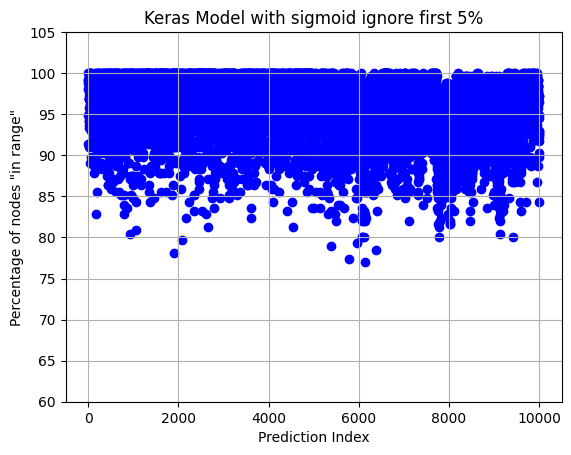

In [ ]:
plt.scatter(np.arange(len(percentages)), percentages, color='blue', marker='o')
plt.title('Keras Model with sigmoid ignore first 5%')
plt.xlabel('Prediction Index')
plt.ylabel('Percentage of nodes "in range"')
plt.grid(True)
plt.ylim(60, 105)
plt.show()

In [ ]:
def find_corr(array_v, array_bool):
  numeric_boolean_values = array_bool.astype(int)
  pearson_corr, pearson_p_value = pearsonr(array_v, numeric_boolean_values)
  spearman_corr, spearman_p_value = spearmanr(array_v, numeric_boolean_values)
  return pearson_corr, pearson_p_value, spearman_corr, spearman_p_value

Check which predictions are right

In [ ]:
result = np.equal(y_test, y_test_predict)

result = result.all(axis=1)

Compute Correlation and Accuracy

In [ ]:
find_corr(percentages, result)

(-0.05205869271856228,
 1.9011666400870245e-07,
 -0.05363271481833214,
 8.029547402952249e-08)

In [ ]:
acc_count = [[0,0],[0,0],[0,0],[0,0]]
for i in range(len(percentages)):
  a = percentages[i]
  if 80. <= a < 85. :
    acc_count[0][0] += 1
    if result[i]:
      acc_count[0][1] += 1
  if 85. <= a < 90. :
    acc_count[1][0] += 1
    if result[i] :
      acc_count[1][1] += 1
  if 90. <= a < 95.:
    acc_count[2][0] += 1
    if result[i] :
      acc_count[2][1] += 1
  if 95. <= a :
    acc_count[3][0] += 1
    if result[i]:
      acc_count[3][1] += 1

In [ ]:
print(f'Accuracy if percentage is between 80 and 85:{acc_count[0][1]/acc_count[0][0]}')
print(f'Accuracy if percentage is between 85 and 90:{acc_count[1][1]/acc_count[1][0]}')
print(f'Accuracy if percentage is between 90 and 95:{acc_count[2][1]/acc_count[2][0]}')
print(f'Accuracy if percentage is between 95 and 100:{acc_count[3][1]/acc_count[3][0]}')

Accuracy if percentage is between 80 and 85:1.0
Accuracy if percentage is between 85 and 90:0.9894578313253012
Accuracy if percentage is between 90 and 95:0.9778830963665087
Accuracy if percentage is between 95 and 100:0.9711725168035847
